## Klasifikace řečníka podle audio záznamu (Směs Gaussovských rozložení) - SUR projekt 2025

- Autor: Vojtěch Orava (xorava02)
- FIT VUT Brno 
- použitá metoda: směs Gaussovských rozložení

Využívá se zde poskytnutá knihovna ikrlib, v níž bylo potřeba upravit některé části kódu (většinou přetypování na **int**), tak aby fungovala s Pythonem 3.10.12

In [1]:

import ikrlib
import importlib
importlib.reload(ikrlib)
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import librosa
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score


### Ořez audio signálu

Z každého audio souboru je odstraněn signál s nedostatečnou energií (odstranění ticha).

Okno MFCC je velké 400 framů / 16000 sampling rate = 25 ms, překrytí je 240 framů (viz knihovna ikrlib).

Zhruba 100 MFCC vzorků na 1s záznamu -> 32s záznam = 3251 vzorků, každý 13 MFCC hodnot

Funkce vypočítá masku, podle níž se určí zda je část záznamu použita nebo ne. Dle masky se provede ořez -> zanechány jsou jen MFCC koeficienty ve kterých není ticho. Funkce taky může vykreslit graf signálu i s prahem rozhodnutí.


In [2]:
def get_silence_mask(filename, clip, do_plot=False, threshold=0.2):

    y, sr = librosa.load(filename)  

    frame_length = 2048
    hop_length  = int(0.01 * sr) # 10 ms time step (takto +- odpovídá počet vzorků MFCC a počet segmentů audio signálu)
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]

    frames = range(len(rms))
    t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)

    # Výchozí práh je 0.2 (20 %)
    threshold_val = threshold * np.max(rms)
    silence_mask = rms > threshold_val

    if do_plot:
        plt.figure(figsize=(12, 4))
        plt.plot(t, rms, label='RMS Energy')
        plt.axhline(threshold_val, color='r', linestyle='--', label='Silence threshold')
        plt.fill_between(t, 0, rms, where=silence_mask, color='gray', alpha=0.4, label='Detected silence')
        
        plt.xlabel('Time (s)')
        plt.ylabel('RMS Energy')
        plt.title(f'RMS Energy mask with silence detection ({filename})')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    return silence_mask[:clip] # ořez na počet vzorků MFCC (n, 13)



### Načtení a příprava trénovacích a testovacích dat

Trénovací a testovací data jsou načtena ze složek **train** a **dev**. 

Po načtení se provede výpočet MFCC hodnot a provede se maskování funkcí *get_silence_mask*. Budou pak použity pouze koeficienty neobsahující ticho.

In [3]:
data_train = []
targets_train = []

data_dev = []
targets_dev = []

silence_masks_train = []
silence_masks_dev = []

for folder in glob('train/*'):
    user_data = ikrlib.wav16khz2mfcc(folder) # extrakce MFCC hodnot
    
    for d in user_data:
        targets_train.append(int(folder.split('/')[1])) # id cílové třídy
        data_train.append(np.array(user_data[d]))
        silence_masks_train.append(get_silence_mask(d, len(user_data[d]), do_plot=False))

for folder in glob('dev/*'):
    user_data = ikrlib.wav16khz2mfcc(folder)
    
    for d in user_data:
        targets_dev.append(int(folder.split('/')[1])) 
        data_dev.append(np.array(user_data[d]))
        silence_masks_dev.append(get_silence_mask(d, len(user_data[d]), do_plot=False))

Processing file:  train/1/f401_01_f12_i0_0.wav
Processing file:  train/1/f401_01_p01_i0_0.wav
Processing file:  train/1/f401_02_f12_i0_0.wav
Processing file:  train/1/f401_02_p01_i0_0.wav
Processing file:  train/1/f401_03_f12_i0_0.wav
Processing file:  train/1/f401_03_p01_i0_0.wav
Processing file:  train/10/f410_01_f12_i0_0.wav
Processing file:  train/10/f410_01_p01_i0_0.wav
Processing file:  train/10/f410_02_f21_i0_0.wav
Processing file:  train/10/f410_02_p01_i0_0.wav
Processing file:  train/10/f410_03_f12_i0_0.wav
Processing file:  train/10/f410_03_p01_i0_0.wav
Processing file:  train/11/f411_01_f12_i0_0.wav
Processing file:  train/11/f411_01_r06_i0_0.wav
Processing file:  train/11/f411_02_f12_i0_0.wav
Processing file:  train/11/f411_02_p01_i0_0.wav
Processing file:  train/11/f411_03_f12_i0_0.wav
Processing file:  train/11/f411_03_p01_i0_0.wav
Processing file:  train/12/f412_01_f12_i0_0.wav
Processing file:  train/12/f412_01_p01_i0_0.wav
Processing file:  train/12/f412_02_f12_i0_0.wa

Vykreslení grafu signálu a masky pro první signál pro ilustraci. Z grafu je vidět, že by mohlo být ustřiženo prvních několik segmentů signálu (vysoká energie na konci je "lupnutí" mikrofonu při začátku nahrávání), ovšem takovýto průběh na začátku nemá každý audio soubor. Proto jsem se rozhodl tento signál neořezávat.

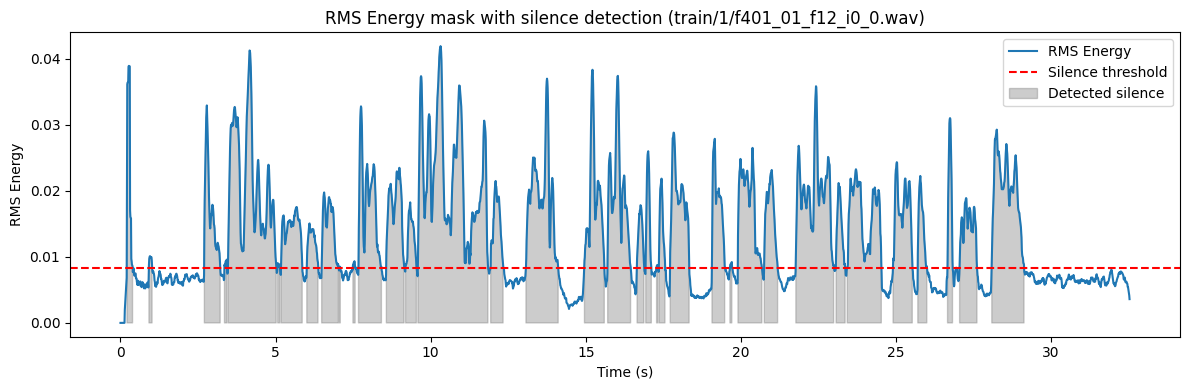

array([False, False, False, ..., False, False, False])

In [4]:
get_silence_mask('train/1/f401_01_f12_i0_0.wav', len(data_train[0]), do_plot=True)

Aplikace masky ticha (silence mask) -> vynechání MFCC řádků které mají malou energii (ticho)

In [5]:
filtered_data_train = []
filtered_data_dev = []

for i in range(len(data_train)):
    one_data = data_train[i]
    filtered_data_train.append(one_data[silence_masks_train[i]])
    #filtered_data_train.append(one_data)
    
for i in range(len(data_dev)):
    one_data = data_dev[i]
    filtered_data_dev.append(one_data[silence_masks_dev[i]]) 
    #filtered_data_dev.append(one_data)
    
def cmvn(feat):
    return (feat - np.mean(feat, axis=1, keepdims=True)) / (np.std(feat, axis=1, keepdims=True) + 1e-10)

for i in range(len(filtered_data_train)):
    filtered_data_train[i] = cmvn(filtered_data_train[i])
    
for i in range(len(filtered_data_dev)):
    filtered_data_dev[i] = cmvn(filtered_data_dev[i])

Data z obou složek teď mají tvar (n, různá_délka, 13), kde **n** je pro složku *train* = 186 a pro složku *dev* = 62, **různá_délka** odpovídá ořezům podle masky ticha a **13** je počet MFCC koeficientů. Následuje rozdělení dat na trénovací a testovací. Nejprve bude klasifikátor natrénován pouze na datech ze složky *train* a otestován na datech ze složky *dev* (tedy 6 trénovacích nahrávek a 2 testovací). Později bude k trénovacím datům přidáno po jednom souboru z každé třídy ze složky *dev* -> k trénování tak bude použito celkem 7 nahrávek a k testování 1 nahrávka na osobu.

In [6]:
X_train = filtered_data_train
X_test = filtered_data_dev

Y_train = targets_train
Y_test = targets_dev

### Natrénování klasifikátoru 

Nejdříve jsou nahrávky od jednoho mluvčího shromažděny do jednoho listu. Poté je nad daty pro každého mluvčího vytvořen a natrénován model GMM.

In [7]:
speakers = {}
for features, label in zip(X_train, Y_train):
    if label not in speakers:
        speakers[label] = []
    speakers[label].append(features)

# pro každou osobu jeden GMM 

gmm_models = {}
for speaker_id, feature_list in speakers.items():    
    all_features = np.vstack(feature_list)  # shape (celkový počet rámců, 13)
    
    gmm = GaussianMixture(
        n_components=16,          
        covariance_type="full",  
        max_iter=1000,
        init_params="kmeans",
        n_init=1
    )
    gmm.fit(all_features)
    gmm_models[speaker_id] = gmm


### Evaluace modelů na testovacích datech

Funkce **predict_speaker** pomocí *score()* vypočítá průměrnou hodnotu log-likelihoodu. GMM s nejvyšším log-likelihoodem je vybrán jako GMM daného mluvčího a ten je tedy zvolen za cílovou třídu.

In [8]:
def predict_speaker(mfcc, gmm_models):
    scores = {}
    for speaker_id, gmm in gmm_models.items():
        frame_log_probs = gmm.score_samples(mfcc)  # log-likelihood pro každý rámec
        total_log_likelihood = frame_log_probs.sum() # suma přes všechny rámce

        scores[speaker_id] = total_log_likelihood
        
    best_speaker = max(scores, key=scores.get)
    return best_speaker

In [9]:
y_true = []
y_pred = []

for mfcc_seq, true_target in zip(X_test, Y_test):
    pred_label = predict_speaker(mfcc_seq, gmm_models)
    y_true.append(true_target)
    y_pred.append(pred_label)

accuracy = accuracy_score(y_true, y_pred)
print(f"Přesnost klasifikace GMM modelem: {accuracy:.4f}")

Přesnost klasifikace GMM modelem: 0.7742


### Více trénovacích dat

Nyní bude k trénování použito 7 nahrávek místo 6 a k testování pouze 1 nahrávka na osobu.

In [10]:
X_train = filtered_data_train
X_train += filtered_data_dev[:31]
X_test = filtered_data_dev[31:]

Y_train = targets_train
Y_train += targets_dev[:31]
Y_test = targets_dev[31:]

In [11]:
print(len(X_train)) #  217 = 31 * 7
print(len(X_test))

217
31


Vytvoření modelu a výpočet přesnosti

In [12]:
speakers = {}
for features, label in zip(X_train, Y_train):
    if label not in speakers:
        speakers[label] = []
    speakers[label].append(features)

# pro každou osobu jeden GMM 
gmm_models2 = {}
for speaker_id, feature_list in speakers.items():    
    all_features = np.vstack(feature_list)  # shape (celkový počet rámců, 13)
    
    gmm = GaussianMixture(
        n_components=16,          
        covariance_type="full",  
        max_iter=1000,
        init_params="kmeans",
        n_init=1
    )
    gmm.fit(all_features)
    gmm_models2[speaker_id] = gmm

In [13]:
y_true = []
y_pred = []

for mfcc_seq, true_target in zip(X_test, Y_test):
    pred_label = predict_speaker(mfcc_seq, gmm_models2)
    y_true.append(true_target)
    y_pred.append(pred_label)

accuracy = accuracy_score(y_true, y_pred)
print(f"Přesnost klasifikace GMM modelem s větším trénovacím datasetem: {accuracy:.4f}")

Přesnost klasifikace GMM modelem s větším trénovacím datasetem: 0.8065


### Predikce na ostrých datech

Nejprve jsou načtena data, poté je na datech provedena predikce, která vrací logaritmické pravděpodobnosti jednotlivých tříd a nakonec jsou výsledky ve formátu dle zadání zapsány do souboru. Očekává se že ostrá data jsou uložena ve složce **main_data**.

In [14]:
data = []
silence_masks = []
names = []

user_data = ikrlib.wav16khz2mfcc('main_data') # extrakce MFCC hodnot
for d in user_data:
    names.append(d.split('/')[1].split('.')[0])
    data.append(np.array(user_data[d]))
    silence_masks.append(get_silence_mask(d, len(user_data[d]), do_plot=False))


Processing file:  main_data/eval_00001.wav
Processing file:  main_data/eval_00002.wav
Processing file:  main_data/eval_00003.wav
Processing file:  main_data/eval_00004.wav
Processing file:  main_data/eval_00005.wav
Processing file:  main_data/eval_00006.wav
Processing file:  main_data/eval_00007.wav
Processing file:  main_data/eval_00008.wav
Processing file:  main_data/eval_00009.wav
Processing file:  main_data/eval_00010.wav
Processing file:  main_data/eval_00011.wav
Processing file:  main_data/eval_00012.wav
Processing file:  main_data/eval_00013.wav
Processing file:  main_data/eval_00014.wav
Processing file:  main_data/eval_00015.wav
Processing file:  main_data/eval_00016.wav
Processing file:  main_data/eval_00017.wav
Processing file:  main_data/eval_00018.wav
Processing file:  main_data/eval_00019.wav
Processing file:  main_data/eval_00020.wav
Processing file:  main_data/eval_00021.wav
Processing file:  main_data/eval_00022.wav
Processing file:  main_data/eval_00023.wav
Processing 

In [15]:
filtered_data = []

for i in range(len(data)):
    one_data = data[i]
    filtered_data.append(one_data[silence_masks[i]])
    
for i in range(len(filtered_data)):
    filtered_data[i] = cmvn(filtered_data[i])
    
print(len(filtered_data)) # počet načtených souborů
X_data = filtered_data

736


Predikce pro celý dataset ostrých dat

In [16]:
y_pred = []


for X in X_data:
    log_likelihoods = np.zeros(31)
    for class_id, gmm in gmm_models2.items():
        log_likelihoods[class_id - 1] = gmm.score(X)
    y_pred.append(log_likelihoods)
    
#np.argmax(y_pred, axis=1) + 1

Zápis do souboru **audio_LR.txt** ve formátu: *název souboru* MEZERA *tvrdé rozhodnutí* MEZERA *logaritmické pravděpodobnosti*

In [17]:
with open('audio_GMM.txt', 'w') as f:
    for i in range(len(y_pred)):
        f.write(f'{names[i]} ')
        f.write(f'{np.argmax(y_pred[i]) + 1} ')
        
        y_towrite = y_pred[i]
        for j in range(len(y_towrite) - 1):
            f.write(f'{y_towrite[j]} ')
            
        f.write(f'{y_towrite[-1]}\n')
        